In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import collections
from pathlib import Path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import openml

from optuna_kfoldCV import evaluate_dataset_with_model, run_all_openML_with_model
from regression_param_specs import evaluate_Ridge, evaluate_XGBoostRegressor

np.set_printoptions(precision=3, threshold=5) # Print options

class Config:
    results_dir = Path.cwd() / "results" / "OpenMLRegression"
    save_dir = Path.cwd() / "save" / "OpenMLRegression"

c:\Users\nz423\Code\random-feature-representation-boosting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Run experiments (just for testing)

In [2]:
# !python regression_param_specs.py \
#     --models Ridge \
#     --dataset_indices 18 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression_TESTING/ \
#     --n_optuna_trials 100 \
#     --device cpu \
#     --k_folds 5 \
#     --cv_seed 42

# join json results

In [2]:
import json
import os
import numpy as np
import pandas as pd

from optuna_kfoldCV import openML_reg_ids


def read_json(path):
    with open(path, "r") as f:
        return json.load(f)
    


def custom_deep_update(original, update):
    for key, value in update.items():
        if isinstance(value, dict) and key in original:
            custom_deep_update(original[key], value)
        else:
            original[key] = value



def get_joined_results_json(
        models = ["End2End", "Ridge", "XGBoostRegressor",
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "RandomFeatureNetwork"],
        datasets = openML_reg_ids,
        save_dir = Config.save_dir,
        ):
    results_json = {}
    for model in models:
        for dataset in datasets:
            path = os.path.join(save_dir, f"regression_{dataset}_{model}.json")
            #print(path)
            res = read_json(path)
            if results_json == {}:
                results_json = res
            else:
                custom_deep_update(results_json, res)
    return results_json



def join_jsons_into_array(
        results_json,
        ):
    results = []
    for dataset, dataset_results in results_json.items():
        res = []
        for model_name, model_results in dataset_results.items():
            model_res = np.stack([model_results["score_train"], model_results["score_test"], model_results["t_fit"], model_results["t_inference"]])
            res.append(model_res)
        results.append(res)
    return np.stack(results) # (n_datasets, n_models, 4, n_folds)


def results_to_df(
        models = ["End2End", "Ridge", "XGBoostRegressor", 
                  "GradientRFRBoost", "GradientRFRBoostID",
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "RandomFeatureNetwork", "RandomFeatureNetwork_iid",
                  ],
        datasets = openML_reg_ids,
        save_dir = Config.save_dir,
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)
    results = join_jsons_into_array(results_json) # (n_datasets, n_models, 4, n_folds)
    
    # Calculate means and stds across folds
    results_mean = np.mean(results, axis=-1)  # (n_datasets, n_models, 4)
    results_std = np.std(results, axis=-1)    # (n_datasets, n_models, 4)
    
    # Create a dictionary to hold both mean and std DataFrames
    metrics = ["score_train", "score_test", "t_fit", "t_inference"]
    metric_dfs = {}
    
    # Initialize DataFrames for both mean and std metrics
    for metric in metrics:
        metric_dfs[metric] = pd.DataFrame(index=datasets, columns=models)
        metric_dfs[f"{metric}_std"] = pd.DataFrame(index=datasets, columns=models)
    
    # Populate the DataFrames for each metric
    for dataset_idx, dataset in enumerate(datasets):
        for model_idx, model in enumerate(models):
            for metric_idx, metric in enumerate(metrics):
                # Set mean value
                metric_dfs[metric].loc[dataset, model] = results_mean[dataset_idx, model_idx, metric_idx]
                # Set* std value
                metric_dfs[f"{metric}_std"].loc[dataset, model] = results_std[dataset_idx, model_idx, metric_idx]
    
    return metric_dfs


In [3]:
models = [
    "End2End_cpu",
    "Ridge",
    "XGBoostRegressor",
    "RFNN",
    "GreedyRFRBoostDiag_batchnormFalse",
    "GreedyRFRBoostScalar_batchnormFalse",
    "GradientRFRBoost_ID_batchnormFalse",
    "GreedyRFRBoostDense_ID_batchnormFalse",
    # "GreedyRFRBoostDiag_batchnormFalse_featiid",
    # "GreedyRFRBoostScalar_batchnormFalse_featiid",
    # "GradientRFRBoost_ID_batchnormFalse_featiid",
    # "GreedyRFRBoostDense_ID_batchnormFalse_featiid",
    # "RFNN_iid",
]

In [4]:
df = results_to_df(        
    models = models,
    )


In [6]:
df["score_test"].mean().sort_values(ascending=True)

XGBoostRegressor                         0.394056
GradientRFRBoost_ID_batchnormFalse       0.408406
GreedyRFRBoostDense_ID_batchnormFalse     0.40842
End2End_cpu                              0.411539
GreedyRFRBoostDiag_batchnormFalse        0.415162
GreedyRFRBoostScalar_batchnormFalse      0.433927
RFNN                                     0.433953
Ridge                                    0.539517
dtype: object

In [7]:
df["score_train"].mean().sort_values(ascending=True)

XGBoostRegressor                          0.23071
End2End_cpu                              0.309848
GreedyRFRBoostDense_ID_batchnormFalse       0.362
GradientRFRBoost_ID_batchnormFalse       0.363327
GreedyRFRBoostDiag_batchnormFalse         0.37397
RFNN                                     0.399995
GreedyRFRBoostScalar_batchnormFalse      0.400043
Ridge                                    0.532423
dtype: object

In [8]:
df["t_fit"].mean().sort_values(ascending=True)

Ridge                                     0.000823
RFNN                                      0.052849
GreedyRFRBoostScalar_batchnormFalse       1.023753
GreedyRFRBoostDiag_batchnormFalse         1.630961
GradientRFRBoost_ID_batchnormFalse        1.687805
XGBoostRegressor                          1.958335
GreedyRFRBoostDense_ID_batchnormFalse     2.733638
End2End_cpu                              19.309407
dtype: object

In [9]:
df["score_test"].rank(axis=1).mean().sort_values()

GradientRFRBoost_ID_batchnormFalse       2.647059
GreedyRFRBoostDense_ID_batchnormFalse    2.764706
XGBoostRegressor                         3.323529
GreedyRFRBoostDiag_batchnormFalse        4.176471
End2End_cpu                              4.558824
GreedyRFRBoostScalar_batchnormFalse      5.617647
RFNN                                     5.705882
Ridge                                    7.205882
dtype: float64

In [10]:
(df["score_test"].rank(axis=1) == 1).sum(axis=0)

End2End_cpu                               5
Ridge                                     1
XGBoostRegressor                         16
RFNN                                      1
GreedyRFRBoostDiag_batchnormFalse         1
GreedyRFRBoostScalar_batchnormFalse       0
GradientRFRBoost_ID_batchnormFalse        6
GreedyRFRBoostDense_ID_batchnormFalse     4
dtype: int64

# Print results

In [5]:
df_renamed = {k:v for k,v in df.items()}
print(df_renamed["score_test"].columns)
for key in df_renamed.keys():
    df_renamed[key] = df_renamed[key].rename(columns={
        "End2End_cpu": "E2E MLP ResNet",
        "Ridge": "Ridge Regression",
        "XGBoostRegressor": "XGBoost",
        "RFNN": "RFNN",
        "GreedyRFRBoostScalar_batchnormFalse": "Greedy RFRBoost $A_{scalar}$",
        "GreedyRFRBoostDiag_batchnormFalse": "Greedy RFRBoost $A_{diag}$",
        "GreedyRFRBoostDense_ID_batchnormFalse": "Greedy RFRBoost $A_{dense}$",
        "GradientRFRBoost_ID_batchnormFalse": "Gradient RFRBoost",
        })
print(df_renamed["score_test"].columns)

# Define the desired column order
new_order = [
    "Ridge Regression",
    "Greedy RFRBoost $A_{scalar}$",
    "Greedy RFRBoost $A_{diag}$",
    "Greedy RFRBoost $A_{dense}$",
    "Gradient RFRBoost",
    "RFNN",
    "E2E MLP ResNet",
    "XGBoost",
]

# Reorder each dataframe in df_renamed by the new column order
for key in df_renamed.keys():
    df_renamed[key] = df_renamed[key][new_order]
    
print(df_renamed["score_test"].columns)

Index(['End2End_cpu', 'Ridge', 'XGBoostRegressor', 'RFNN',
       'GreedyRFRBoostDiag_batchnormFalse',
       'GreedyRFRBoostScalar_batchnormFalse',
       'GradientRFRBoost_ID_batchnormFalse',
       'GreedyRFRBoostDense_ID_batchnormFalse'],
      dtype='object')
Index(['E2E MLP ResNet', 'Ridge Regression', 'XGBoost', 'RFNN',
       'Greedy RFRBoost $A_{diag}$', 'Greedy RFRBoost $A_{scalar}$',
       'Gradient RFRBoost', 'Greedy RFRBoost $A_{dense}$'],
      dtype='object')
Index(['Ridge Regression', 'Greedy RFRBoost $A_{scalar}$',
       'Greedy RFRBoost $A_{diag}$', 'Greedy RFRBoost $A_{dense}$',
       'Gradient RFRBoost', 'RFNN', 'E2E MLP ResNet', 'XGBoost'],
      dtype='object')


/tmp/ipykernel_7827/3898179558.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


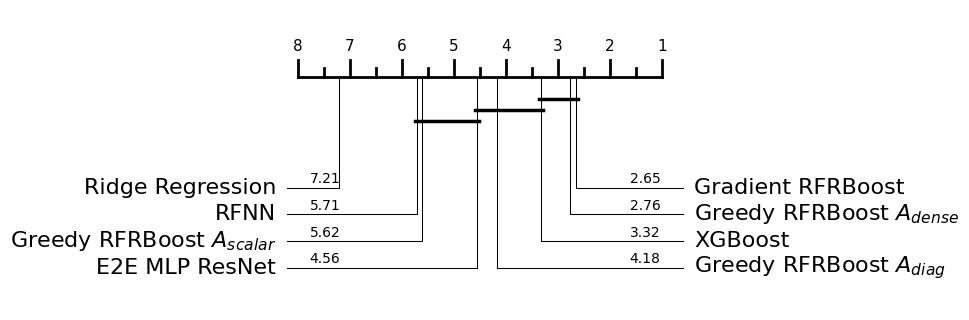

In [12]:
from aeon.visualisation import plot_critical_difference, plot_significance
import matplotlib.pyplot as plt

# Generate the plot
plot = plot_critical_difference(df_renamed["score_test"].values,
                                df_renamed["score_test"].columns.tolist(), 
                                alpha=0.05, 
                                lower_better=True,
                                digits=2,
                                width=7, #default 6
                                textspace=1.8, #default 1.5
                                )

# Retrieve the figure and axes from the plot
fig = plot[0].figure
ax = plot[0]

# Adjust figure size
fig.set_size_inches(6, 3)

# Adjust layout
fig.tight_layout()

# Save the figures
plot[0].savefig(Config.results_dir / "OpenMLReg_critical_difference.eps", bbox_inches='tight')
plot[0].savefig(Config.results_dir / "OpenMLReg_critical_difference.png", bbox_inches='tight')

In [13]:
import pandas as pd
import numpy as np

def create_latex_table(
        df_scores: pd.DataFrame, 
        df_t_fit: pd.DataFrame, 
        decimals: int = 3, 
        include_std: bool = False) -> str:
    table = """\\begin{table}[t]
\\caption{Average test RMSE and fit times on the OpenML regression tasks.}
\\label{tab:openml-regression}
\\vskip 0.15in
\\begin{center}
\\begin{small}
\\begin{sc}
\\begin{tabular}{lcc}
\\toprule
Model & RMSE & Fit Time (s) \\\\
\\midrule
"""
    # Calculate means and stds
    score_means = df_scores.mean()
    score_stds = df_scores.std()
    time_means = df_t_fit.mean()
    time_stds = df_t_fit.std()
    
    # Create sorted index based on scores
    sorted_idx = score_means.sort_values(ascending=True).index
    
    # Create formatted rows
    for model in sorted_idx:
        if include_std:
            score_str = f"{score_means[model]:.{decimals}f} ({score_stds[model]:.{decimals}f})"
            time_str = f"{time_means[model]:.{decimals}f} ({time_stds[model]:.{decimals}f})"
        else:
            score_str = f"{score_means[model]:.{decimals}f}"
            time_str = f"{time_means[model]:.{decimals}f}"
        table += f"{model} & {score_str} & {time_str} \\\\\n"
    
    table += """\\bottomrule
\\end{tabular}
\\end{sc}
\\end{small}
\\end{center}
\\vskip -0.1in
\\end{table}
"""
    return table


#usage
latex_table = create_latex_table(df_renamed["score_test"], df_renamed["t_fit"])
print(latex_table)

\begin{table}[t]
\caption{Average test RMSE and fit times on the OpenML regression tasks.}
\label{tab:openml-regression}
\vskip 0.15in
\begin{center}
\begin{small}
\begin{sc}
\begin{tabular}{lcc}
\toprule
Model & RMSE & Fit Time (s) \\
\midrule
XGBoost & 0.394 & 1.958 \\
Gradient RFRBoost & 0.408 & 1.688 \\
Greedy RFRBoost $A_{dense}$ & 0.408 & 2.734 \\
E2E MLP ResNet & 0.412 & 19.309 \\
Greedy RFRBoost $A_{diag}$ & 0.415 & 1.631 \\
Greedy RFRBoost $A_{scalar}$ & 0.434 & 1.024 \\
RFNN & 0.434 & 0.053 \\
Ridge Regression & 0.540 & 0.001 \\
\bottomrule
\end{tabular}
\end{sc}
\end{small}
\end{center}
\vskip -0.1in
\end{table}



# Full Results TODO

In [10]:
import pandas as pd


def create_appendix_table(df, df_std, caption="Test RMSE scores on OpenML regression datasets.", 
                          label="tab:appendix-regression", decimals=3):
    """
    Create a LaTeX table for a paper showing model results per dataset.
    The best (lowest) score in each row is highlighted in bold.
    Standard deviations are shown in parentheses.
    Model names are broken across multiple lines for better fit using \makecell.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with datasets as rows, models as columns, and scores as values.
    df_std : pandas.DataFrame
        DataFrame with the same shape as df, containing standard deviations.
    caption : str
        Table caption.
    label : str
        Table reference label.
    decimals : int
        Number of decimal places to display.

    Returns:
    --------
    str : LaTeX table code
    """
    formatted_df = df.copy()

    # Format scores and bold the best (lowest) in each row
    for idx, row in df.iterrows():
        min_val = row.min()
        for col in df.columns:
            val = row[col]
            std = df_std.at[idx, col]
            val_str = f"{val:.{decimals}f}"
            std_str = f"({std:.{decimals}f})"
            if val == min_val:
                formatted_df.at[idx, col] = f"\\textbf{{{val_str}}} {std_str}"
            else:
                formatted_df.at[idx, col] = f"{val_str} {std_str}"

    # Properly break model names using \makecell
    new_columns = []
    for col in formatted_df.columns:
        broken_col = col.replace(" ", " \\\\ ")
        new_columns.append(f"\\makecell{{{broken_col}}}")
    formatted_df.columns = new_columns

    # Generate LaTeX table
    latex = "\\begin{table}[h!]\n\\centering\n"
    latex += f"\\caption{{{caption}}}\n"
    latex += f"\\label{{{label}}}\n"
    latex += "\\vskip 0.2in\n"
    latex += formatted_df.to_latex(escape=False, column_format='l|' + 'c' * len(df.columns))
    latex += "\\end{table}"

    return latex


# Generate the appendix table with the best scores in bold
appendix_table = create_appendix_table(df_renamed["score_test"], df_renamed["score_test_std"])
print(appendix_table)

\begin{table}[h!]
\centering
\caption{Test RMSE scores on OpenML regression datasets.}
\label{tab:appendix-regression}
\vskip 0.2in
\begin{tabular}{l|cccccccc}
\toprule
 & \makecell{Ridge \\ Regression} & \makecell{Greedy \\ RFRBoost \\ $A_{scalar}$} & \makecell{Greedy \\ RFRBoost \\ $A_{diag}$} & \makecell{Greedy \\ RFRBoost \\ $A_{dense}$} & \makecell{Gradient \\ RFRBoost} & \makecell{RFNN} & \makecell{E2E \\ MLP \\ ResNet} & \makecell{XGBoost} \\
\midrule
41021 & 0.233 (0.012) & 0.233 (0.013) & 0.232 (0.013) & 0.231 (0.012) & \textbf{0.231} (0.011) & 0.232 (0.012) & 0.265 (0.011) & 0.249 (0.011) \\
44956 & 0.647 (0.020) & 0.631 (0.018) & 0.621 (0.019) & 0.615 (0.019) & 0.616 (0.020) & 0.622 (0.022) & \textbf{0.614} (0.023) & 0.633 (0.020) \\
44957 & 0.688 (0.033) & 0.362 (0.026) & 0.246 (0.017) & 0.238 (0.011) & 0.233 (0.013) & 0.347 (0.021) & 0.316 (0.026) & \textbf{0.197} (0.015) \\
44958 & 0.595 (0.010) & 0.239 (0.019) & 0.205 (0.010) & 0.193 (0.016) & 0.191 (0.027) & 0.246 (0.02

# plot scatter plot with box and whiskers

/tmp/ipykernel_7827/2966563945.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap, len(models))


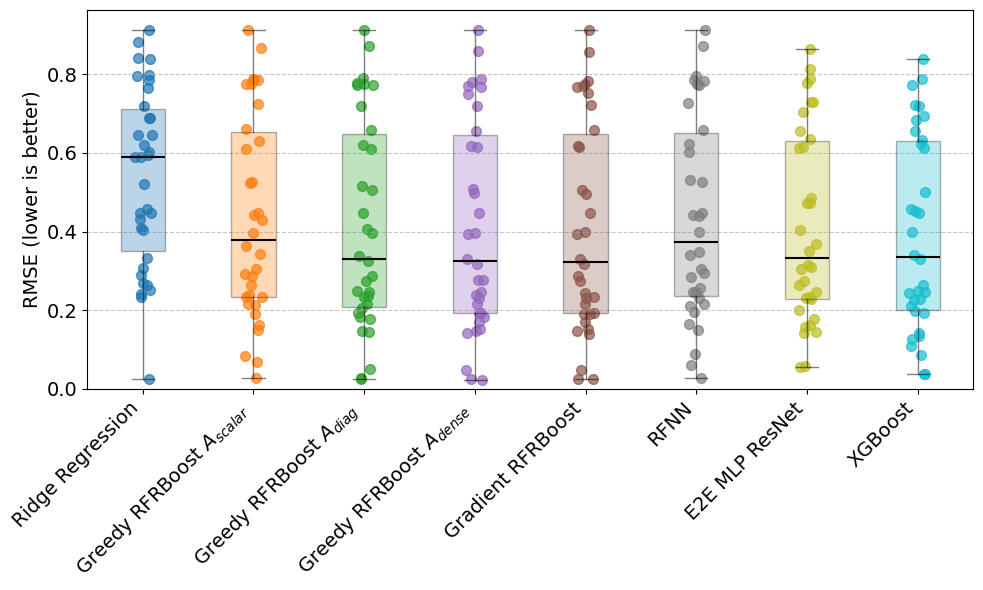

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter_and_box_and_whisker(df, y_label="RMSE", figsize=(10, 6), 
                                   save_path=None, colormap='tab10', jitter=0.08,
                                   y_label_fontsize=14, x_tick_fontsize=14, y_tick_fontsize=14):
    """
    Create a scatter plot with overlaid box-and-whisker plots for model accuracies.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing model accuracies. Rows are datasets, columns are models.
    y_label : str, optional
        Label for the y-axis. Default is "Accuracy".
    figsize : tuple, optional
        Figure size (width, height) in inches. Default is (10, 6).
    save_path : str, optional
        Path to save the figure. If None, the figure is not saved.
    colormap : str, optional
        Matplotlib colormap name to use for the plots. Default is 'tab10'.
    jitter : float, optional
        Amount of horizontal jitter to add to scatter points. Default is 0.08.
    y_label_fontsize : int, optional
        Font size for the y-axis label. Default is 12.
    x_tick_fontsize : int, optional
        Font size for the x-axis tick labels (model names). Default is 10.
    y_tick_fontsize : int, optional
        Font size for the y-axis tick labels. Default is 10.
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get model names
    models = df.columns
    
    # Generate colors for each model
    cmap = plt.cm.get_cmap(colormap, len(models))
    
    positions = np.arange(1, len(models) + 1)
    
    # Plot scatter points for each model
    for i, model in enumerate(models):
        # Add random jitter to x-positions for better visibility
        x_jitter = np.random.uniform(-jitter, jitter, size=len(df))
        
        # Plot scatter points with some transparency
        ax.scatter(positions[i] + x_jitter, df[model], 
                  color=cmap(i), alpha=0.7, s=50, label=f"{model} datasets")
    
    # Create box plots on top of scatter points with higher transparency
    # and no outlier markers (showfliers=False)
    bp = ax.boxplot(
        [df[model].values for model in models], 
        positions=positions, 
        widths=0.4, 
        patch_artist=True,
        boxprops=dict(alpha=0.3, linewidth=1.2),  # More transparent boxes
        medianprops=dict(color='black', linewidth=1.5),
        whiskerprops=dict(alpha=0.5, linewidth=1.0),
        capprops=dict(alpha=0.5, linewidth=1.0),
        showfliers=False  # Remove the outlier markers
    )
    
    # Color the boxes
    for i, box in enumerate(bp['boxes']):
        box.set(facecolor=cmap(i), linewidth=1.0)
        
    # Set custom y-axis label with customizable font size
    ax.set_ylabel(y_label, fontsize=y_label_fontsize)
    
    # Set x-ticks and labels with customizable font size
    ax.set_xticks(positions)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=x_tick_fontsize)
    
    # Set y-tick font size
    ax.tick_params(axis='y', labelsize=y_tick_fontsize)
    
    ax.grid(True, linestyle='--', alpha=0.7, axis='y')
    
    # Set y-axis limits with a bit of padding
    y_min = max(0, df.values.min() - 0.05)  # Don't go below 0 for accuracy
    y_max = min(1.05, df.values.max() + 0.05)  # Updated to 1.05 instead of 1
    ax.set_ylim(y_min, y_max)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
    
    return fig


fig = plot_scatter_and_box_and_whisker(
    df_renamed["score_test"], 
    y_label="RMSE (lower is better)",
    save_path=Config.results_dir / "OpenMLReg_scatter_boxplot.png",  
    )

# Swim vs IID ablation TODO

In [16]:
ablation_df = results_to_df(        
    models = [
        "GreedyRFRBoostDiag_batchnormFalse_featiid",
        "GreedyRFRBoostScalar_batchnormFalse_featiid",
        "GradientRFRBoost_ID_batchnormFalse_featiid",
        "GreedyRFRBoostDense_ID_batchnormFalse_featiid",
        "RFNN",
        "GreedyRFRBoostDiag_batchnormFalse",
        "GreedyRFRBoostScalar_batchnormFalse",
        "GradientRFRBoost_ID_batchnormFalse",
        "GreedyRFRBoostDense_ID_batchnormFalse",
        "RFNN_iid",
                ],
    )

ablation_df["score_test"]

,GreedyRFRBoostDiag_batchnormFalse_featiid,GreedyRFRBoostScalar_batchnormFalse_featiid,GradientRFRBoost_ID_batchnormFalse_featiid,GreedyRFRBoostDense_ID_batchnormFalse_featiid,RFNN,GreedyRFRBoostDiag_batchnormFalse,GreedyRFRBoostScalar_batchnormFalse,GradientRFRBoost_ID_batchnormFalse,GreedyRFRBoostDense_ID_batchnormFalse,RFNN_iid
41021,0.233262,0.231878,0.232365,0.232189,0.231623,0.232425,0.232732,0.230791,0.231201,0.233062
44956,0.621997,0.625589,0.61592,0.611568,0.62222,0.620682,0.631083,0.616491,0.614599,0.619703
44957,0.238241,0.359824,0.266373,0.271674,0.346936,0.246165,0.36223,0.233092,0.23769,0.385095
44958,0.238976,0.293757,0.248098,0.252255,0.245631,0.204856,0.239493,0.190878,0.192834,0.291678
44959,0.263669,0.318415,0.320351,0.321762,0.304906,0.275035,0.3041,0.285811,0.277119,0.335345
44960,0.068482,0.188676,0.051502,0.05269,0.088459,0.050413,0.068582,0.048899,0.04913,0.091272
44962,0.446908,0.447631,0.446111,0.446128,0.447362,0.447624,0.447828,0.446656,0.446096,0.44747
44963,0.749695,0.78003,0.733553,0.735598,0.782882,0.772871,0.784431,0.751967,0.749371,0.767753
44964,0.39735,0.44482,0.396952,0.399555,0.442738,0.406487,0.442843,0.398005,0.395281,0.458947
44965,0.867691,0.879346,0.871561,0.869558,0.870884,0.872741,0.866517,0.85789,0.859849,0.879018


In [17]:
ablation_df["score_test"].mean().sort_values(ascending=True)

GradientRFRBoost_ID_batchnormFalse               0.408406
GreedyRFRBoostDense_ID_batchnormFalse             0.40842
GradientRFRBoost_ID_batchnormFalse_featiid       0.414534
GreedyRFRBoostDiag_batchnormFalse                0.415162
GreedyRFRBoostDiag_batchnormFalse_featiid        0.415472
GreedyRFRBoostDense_ID_batchnormFalse_featiid    0.415652
GreedyRFRBoostScalar_batchnormFalse              0.433927
RFNN                                             0.433953
RFNN_iid                                         0.440535
GreedyRFRBoostScalar_batchnormFalse_featiid      0.442737
dtype: object

In [18]:
ablation_df["t_fit"].mean().sort_values(ascending=True)

RFNN_iid                                         0.028656
RFNN                                             0.052849
GreedyRFRBoostScalar_batchnormFalse_featiid      0.720032
GreedyRFRBoostScalar_batchnormFalse              1.023753
GreedyRFRBoostDiag_batchnormFalse_featiid        1.490188
GreedyRFRBoostDiag_batchnormFalse                1.630961
GradientRFRBoost_ID_batchnormFalse               1.687805
GradientRFRBoost_ID_batchnormFalse_featiid       1.815875
GreedyRFRBoostDense_ID_batchnormFalse_featiid    2.667469
GreedyRFRBoostDense_ID_batchnormFalse            2.733638
dtype: object

In [19]:
ablation_df["score_test"].rank(axis=1).mean().sort_values()

GreedyRFRBoostDense_ID_batchnormFalse            2.911765
GradientRFRBoost_ID_batchnormFalse               3.147059
GradientRFRBoost_ID_batchnormFalse_featiid       4.029412
GreedyRFRBoostDense_ID_batchnormFalse_featiid    4.382353
GreedyRFRBoostDiag_batchnormFalse_featiid        5.000000
GreedyRFRBoostDiag_batchnormFalse                5.147059
RFNN                                             7.323529
RFNN_iid                                         7.352941
GreedyRFRBoostScalar_batchnormFalse              7.382353
GreedyRFRBoostScalar_batchnormFalse_featiid      8.323529
dtype: float64

In [20]:
def plot_comparison(
    SWIM_df: pd.Series,
    IID_df: pd.Series,
    model_name: str,
    results_dir: Path = Config.results_dir,
    fontsize: int = 16,
    title_fontsize: int = 18,
    figsize: Tuple[int, int] = (6, 6),
):
    """
    Plot a comparison of SWIM and IID RMSE for a given model.
    
    Parameters:
    -----------
    SWIM_df : pd.Series
    Series containing SWIM model RMSE values
    IID_df : pd.Series
    Series containing i.i.d. model RMSE values
    model_name : str
    Name of the model for the plot title and filename
    results_dir : Path
    Directory to save the figure
    fontsize : int
    Font size for labels and annotations
    title_fontsize : int
    Font size for the plot title
    figsize : Tuple[int, int]
    Figure dimensions (width, height)
    """
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    plt.scatter(
    SWIM_df,
    IID_df,
    alpha=0.7,
    s=60
    )

    # Get min and max values for axis limits with some padding
    min_val = min(SWIM_df.min(), IID_df.min()) * 0.9
    max_val = max(SWIM_df.max(), IID_df.max()) * 1.1
    
    # Add diagonal line for reference
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    
    # Add region annotations
    plt.text(
    max_val * 0.7, 
    max_val * 0.3, 
    "i.i.d. wins here", 
    fontsize=fontsize,
    color='red',
    ha='center',
    )
    
    plt.text(
    max_val * 0.3, 
    max_val * 0.7, 
    "SWIM wins here", 
    fontsize=fontsize,
    color='green',
    ha='center',
    )
    
    # Count wins
    swim_wins = sum(SWIM_df < IID_df)
    iid_wins = sum(IID_df < SWIM_df)
    ties = sum(SWIM_df == IID_df)
    
    # Add win counts to title
    win_text = f"SWIM wins: {swim_wins}, i.i.d. wins: {iid_wins}, ties: {ties}"
    
    # Customize plot
    plt.xlabel("SWIM RMSE", fontsize=fontsize)
    plt.ylabel("i.i.d. RMSE", fontsize=fontsize)
    plt.title(f"{model_name}\n{win_text}", fontsize=title_fontsize)
    plt.tick_params(axis='both', which='major', labelsize=fontsize-2)
    
    # Set equal aspect ratio and limits
    plt.axis([min_val, max_val, min_val, max_val])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save the figure
    plt.savefig(results_dir / f"{model_name.replace('$', '')}_comparison.png", bbox_inches='tight', dpi=300)
    plt.show()

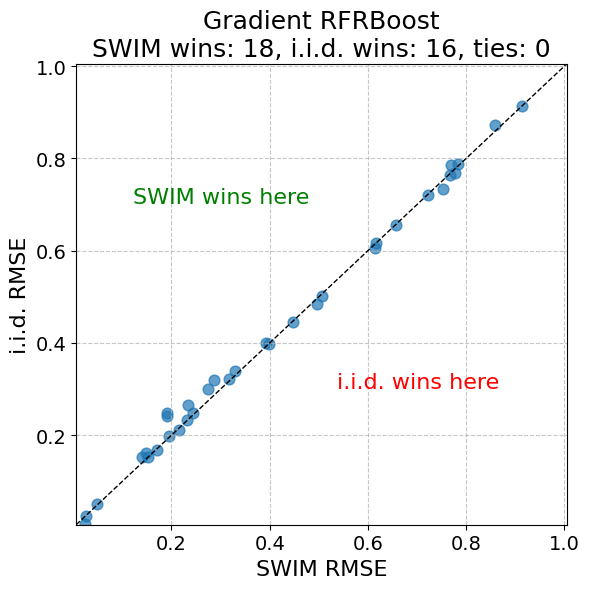

In [21]:
plot_comparison(
    ablation_df["score_test"]["GradientRFRBoost_ID_batchnormFalse"],
    ablation_df["score_test"]["GradientRFRBoost_ID_batchnormFalse_featiid"],
    model_name="Gradient RFRBoost",
)

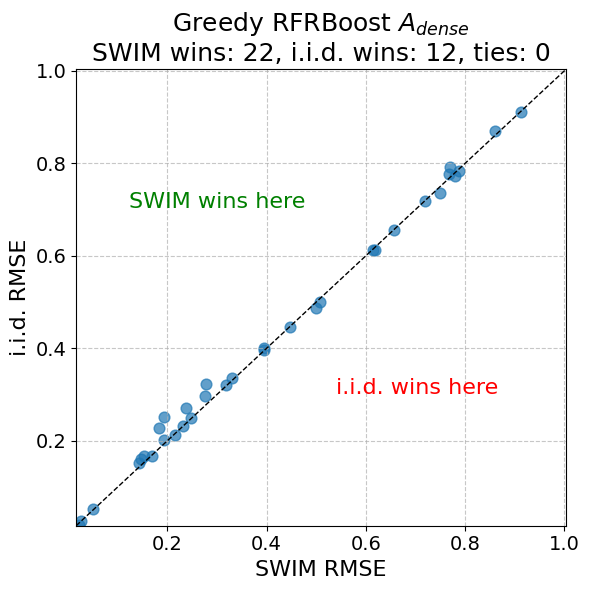

In [22]:
plot_comparison(
    ablation_df["score_test"]["GreedyRFRBoostDense_ID_batchnormFalse"],
    ablation_df["score_test"]["GreedyRFRBoostDense_ID_batchnormFalse_featiid"],
    model_name="Greedy RFRBoost $A_{dense}$",
)

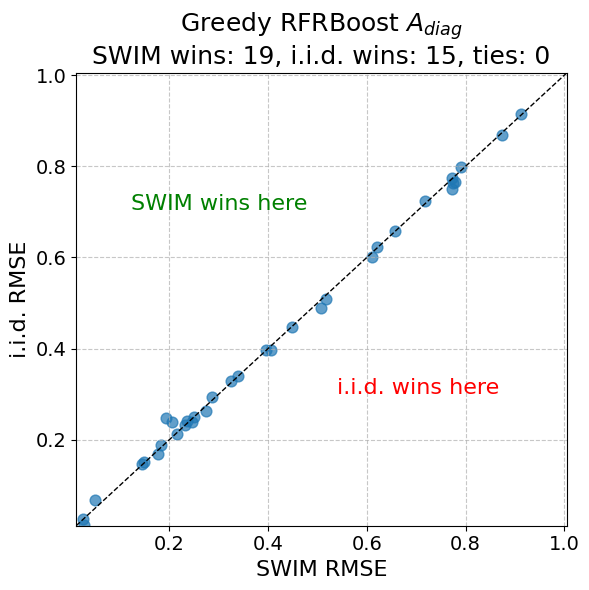

In [23]:
plot_comparison(
    ablation_df["score_test"]["GreedyRFRBoostDiag_batchnormFalse"],
    ablation_df["score_test"]["GreedyRFRBoostDiag_batchnormFalse_featiid"],
    model_name="Greedy RFRBoost $A_{diag}$",
)

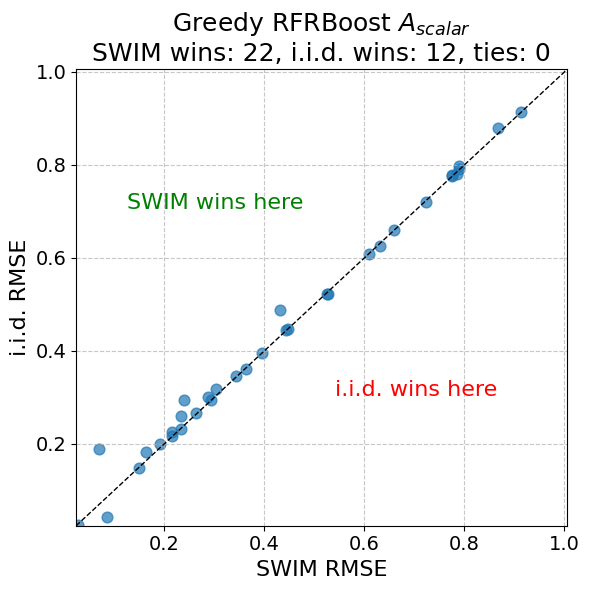

In [24]:
plot_comparison(
    ablation_df["score_test"]["GreedyRFRBoostScalar_batchnormFalse"],
    ablation_df["score_test"]["GreedyRFRBoostScalar_batchnormFalse_featiid"],
    model_name="Greedy RFRBoost $A_{scalar}$",
)

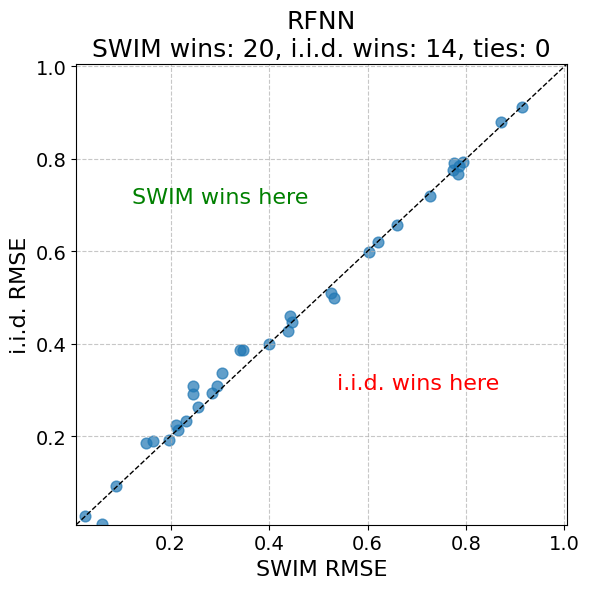

In [25]:
plot_comparison(
    ablation_df["score_test"]["RFNN"],
    ablation_df["score_test"]["RFNN_iid"],
    model_name="RFNN",
)

In [26]:
plot_paths = [
    Config.results_dir / "Gradient RFRBoost_comparison.png",
    Config.results_dir / "RFNN_comparison.png",
    Config.results_dir / "Greedy RFRBoost A_{scalar}_comparison.png",
    Config.results_dir / "Greedy RFRBoost A_{diag}_comparison.png",
    Config.results_dir / "Greedy RFRBoost A_{dense}_comparison.png",
]

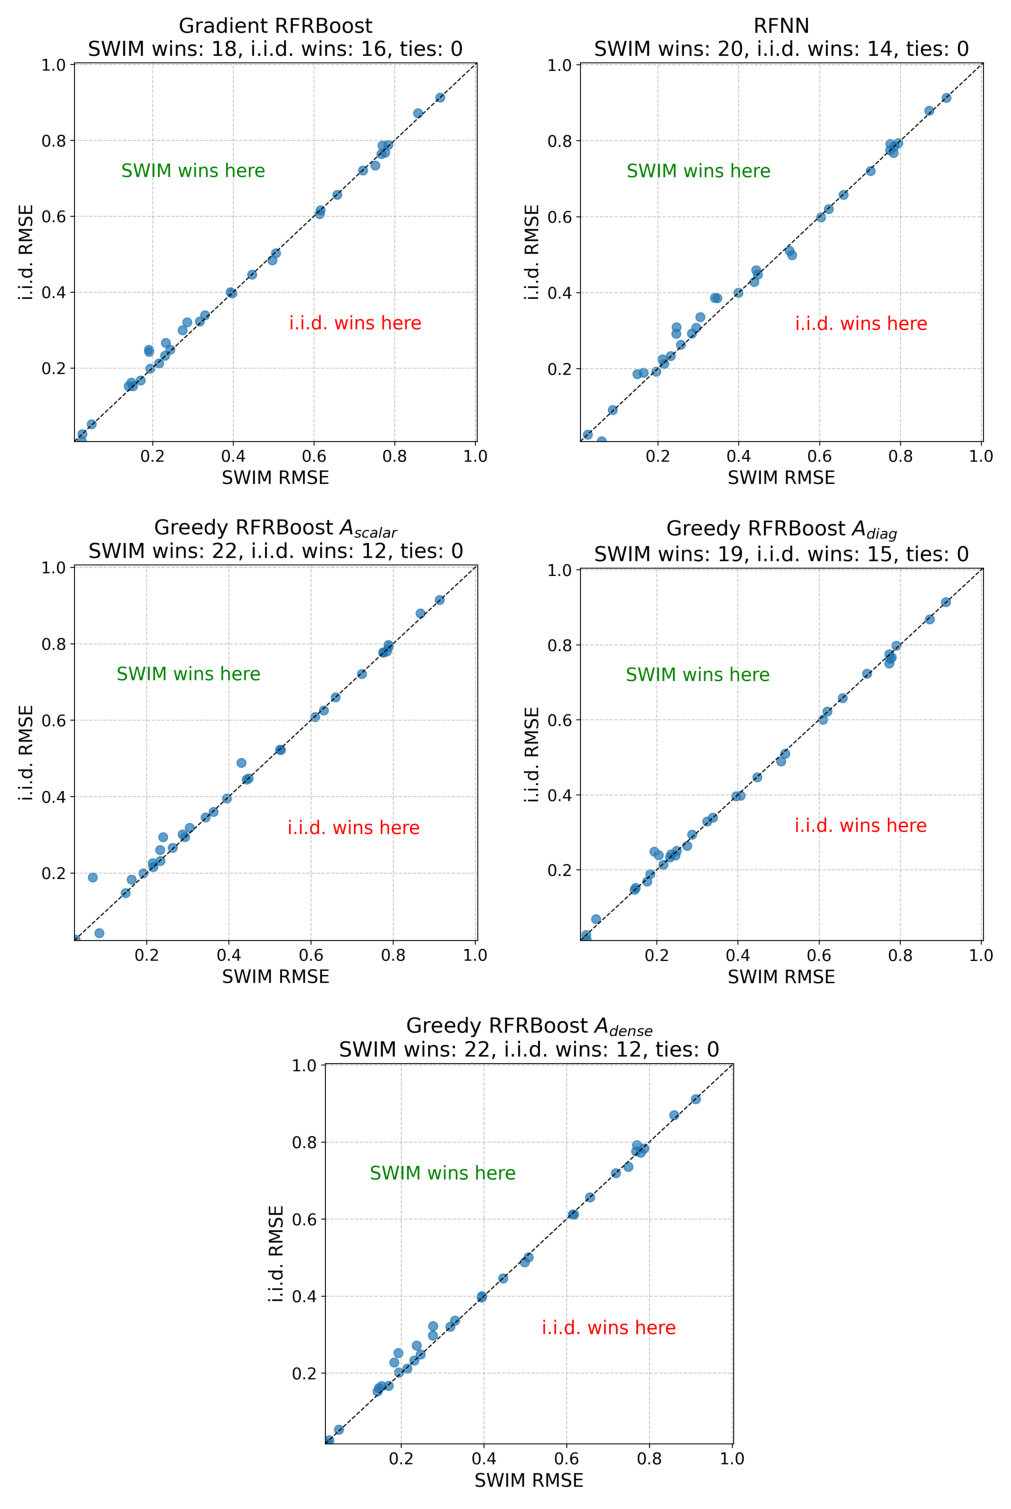

In [27]:
def combine_comparison_plots(plot_paths, save_path=None, figsize=(10, 15)):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from matplotlib.gridspec import GridSpec

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(3, 2, figure=fig)

    # Assign plots
    axes = [
        fig.add_subplot(gs[0, 0]),  # Top-left
        fig.add_subplot(gs[0, 1]),  # Top-right
        fig.add_subplot(gs[1, 0]),  # Mid-left
        fig.add_subplot(gs[1, 1]),  # Mid-right
        fig.add_subplot(gs[2, :])   # Bottom: spans both columns
    ]

    for ax, path in zip(axes, plot_paths):
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.axis('off')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    return fig

# Usage
combined_fig = combine_comparison_plots(
    plot_paths=plot_paths,
    save_path=Config.results_dir / "combined_comparison_plots_regression.png"
)

In [35]:
def create_swim_iid_comparison_table(ablation_df, models_thruple):
    """
    Creates a LaTeX table comparing SWIM vs IID model performance.
    
    Parameters:
    -----------
    ablation_df : dict
        Dictionary containing DataFrames with model results
    models_thruple : list
        List of tuples with (iid_model_name, swim_model_name, display_name)
        
    Returns:
    --------
    str : LaTeX table code
    """
    # Create table header
    table = """\\begin{table}[t]
\\caption{Comparison of SWIM vs i.i.d. feature initialization on OpenML regression tasks.}
\\label{tab:swim-iid-comparison}
\\vskip 0.15in
\\begin{center}
\\begin{small}
\\begin{sc}
\\begin{tabular}{lc|ccc}
\\toprule
Model & Variant & RMSE & Wins & Fit Time (s) \\\\
\\midrule
"""
    
    # Process each model pair
    for i, (iid_model, swim_model, display_name) in enumerate(models_thruple):
        # Calculate wins
        swim_wins = (ablation_df["score_test"][swim_model] < ablation_df["score_test"][iid_model]).sum()
        iid_wins = (ablation_df["score_test"][iid_model] < ablation_df["score_test"][swim_model]).sum()
        ties = len(ablation_df["score_test"]) - swim_wins - iid_wins
        
        # Calculate means
        swim_mean = ablation_df["score_test"][swim_model].mean()
        iid_mean = ablation_df["score_test"][iid_model].mean()
        
        # Calculate fit times
        swim_fit = ablation_df["t_fit"][swim_model].mean()
        iid_fit = ablation_df["t_fit"][iid_model].mean()
        
        # Add SWIM row
        table += f"{display_name} & SWIM & {swim_mean:.3f} & {swim_wins} & {swim_fit:.3f} \\\\\n"
        # Add IID row
        table += f"& i.i.d. & {iid_mean:.3f} & {iid_wins} & {iid_fit:.3f} \\\\\n"
        
        # Add midrule except after the last model
        if i < len(models_thruple) - 1:
            table += "\\midrule\n"
    
    # Close the table
    table += """\\bottomrule
\\end{tabular}
\\end{sc}
\\end{small}
\\end{center}
\\vskip -0.1in
\\end{table}
"""
    return table



# Define model pairs (correct the model names to match actual data)
models_thruple = [
    ["RFNN_iid", "RFNN", "RFNN"],
    ["GradientRFRBoost_ID_batchnormFalse_featiid", "GradientRFRBoost_ID_batchnormFalse", "Gradient RFRBoost"],
    ["GreedyRFRBoostDense_ID_batchnormFalse_featiid", "GreedyRFRBoostDense_ID_batchnormFalse", "Greedy RFRBoost $A_{dense}$"],
    ["GreedyRFRBoostDiag_batchnormFalse_featiid", "GreedyRFRBoostDiag_batchnormFalse", "Greedy RFRBoost $A_{diag}$"],
    ["GreedyRFRBoostScalar_batchnormFalse_featiid", "GreedyRFRBoostScalar_batchnormFalse", "Greedy RFRBoost $A_{scalar}$"],
]

# Generate and print the table
swim_iid_table = create_swim_iid_comparison_table(ablation_df, models_thruple)
print(swim_iid_table)


\begin{table}[t]
\caption{Comparison of SWIM vs i.i.d. feature initialization on OpenML regression tasks.}
\label{tab:swim-iid-comparison}
\vskip 0.15in
\begin{center}
\begin{small}
\begin{sc}
\begin{tabular}{lc|ccc}
\toprule
Model & Variant & RMSE & Wins & Fit Time (s) \\
\midrule
RFNN & SWIM & 0.434 & 20 & 0.053 \\
& i.i.d. & 0.441 & 14 & 0.029 \\
\midrule
Gradient RFRBoost & SWIM & 0.408 & 18 & 1.688 \\
& i.i.d. & 0.415 & 16 & 1.816 \\
\midrule
Greedy RFRBoost $A_{dense}$ & SWIM & 0.408 & 22 & 2.734 \\
& i.i.d. & 0.416 & 12 & 2.667 \\
\midrule
Greedy RFRBoost $A_{diag}$ & SWIM & 0.415 & 19 & 1.631 \\
& i.i.d. & 0.415 & 15 & 1.490 \\
\midrule
Greedy RFRBoost $A_{scalar}$ & SWIM & 0.434 & 22 & 1.024 \\
& i.i.d. & 0.443 & 12 & 0.720 \\
\bottomrule
\end{tabular}
\end{sc}
\end{small}
\end{center}
\vskip -0.1in
\end{table}

